In [1]:
import torch
import random
import pandas as pd
import pickle as pkl
from tqdm import tqdm
from os import listdir
from os.path import join
from random import shuffle
from transformers import AdamW
from matplotlib import pyplot as plt
from torch.nn import CrossEntropyLoss
from transformers import get_scheduler
from pdb import set_trace as breakpoint
from nltk.stem.snowball import SnowballStemmer
from torch.utils.data import Dataset, DataLoader
from transformers import BartTokenizer, BartForConditionalGeneration

In [2]:
%matplotlib inline

In [3]:
# folders = ['bags_and_cases', 'bluetooth', 'boots', 'keyboards', 'tv', 'vacuums']

# base_dir = '/mnt/nfs/work1/hongyu/brawat/amzn/oposum/data/seeds'

# list_aspects = []
# Aspect_to_seeds = {}
# stemmer = SnowballStemmer(language='english')
# for each_folder in folders:
#     folder_dir = join(base_dir, each_folder)
#     print('--'*20)
#     print(each_folder)
#     print('--'*20)
#     txt_files = listdir(folder_dir)
#     txt_files = [x for x in txt_files if 'None' not in x]
#     print(txt_files)
#     for each_txt in txt_files:
#         txt_dir = join(folder_dir, each_txt)
#         txt = open(txt_dir).read()
#         txt = txt.split('\n')
#         txt = [x.split(' ')[-1] for x in txt]
#         txt = [x.strip() for x in txt]
#         txt = [stemmer.stem(x) for x in txt]
#         aspect = each_txt.split('.')[1]
#         Aspect_to_seeds[aspect] = txt

In [4]:
# for each_aspect in Aspect_to_seeds:
#     print(each_aspect, Aspect_to_seeds[each_aspect].__len__())

In [5]:
# pkl.dump(Aspect_to_seeds, open('Aspect_to_seeds_march19.pkl', 'wb'))

In [6]:
Aspect_to_seeds = pkl.load(open('Aspect_to_seeds_march19.pkl', 'rb'))

In [7]:
for each_aspect in Aspect_to_seeds:
    Aspect_to_seeds[each_aspect] = [x for x in Aspect_to_seeds[each_aspect] if x.__len__()>0][:25]

In [8]:
Aspect_to_seeds

{'Compartments': ['pocket',
  'cabl',
  'compart',
  'outsid',
  'lot',
  'wish',
  'wallet',
  'connector',
  'space',
  'power',
  'pen',
  'folder',
  'charger',
  'flap',
  'mous',
  'nice',
  'thing',
  'insid',
  'small',
  'paperwork',
  'accessori',
  'daytim',
  'jacket',
  'raincoat',
  'nois'],
 'Price': ['price',
  'money',
  'feaur',
  'paid',
  'spin',
  'spun',
  'mayb',
  'cheap',
  '200',
  'spend',
  'right',
  'vaccum',
  'twice',
  'expect',
  'pricey',
  '50',
  'expens',
  'worth',
  'far',
  'wast',
  'duster',
  'think',
  'bagless',
  'best',
  'dyson'],
 'Handles': ['strap',
  'handl',
  'shoulder',
  'broke',
  'later',
  'month',
  'hand',
  'comfort',
  'plastic',
  'wear',
  'tear',
  'rip',
  'start',
  'attach',
  'holiday',
  'left',
  'lift',
  'final',
  'broken',
  'stand',
  'inevit',
  'situat',
  'firm',
  'bend',
  'hurt'],
 'Customer_service': ['paid',
  'support',
  'servic',
  'week',
  'replac',
  'mail',
  'wait',
  'pay',
  'ship',
  '1500'

In [9]:
for each_aspect in Aspect_to_seeds:
    print(each_aspect, Aspect_to_seeds[each_aspect].__len__())

Compartments 25
Price 25
Handles 25
Customer_service 25
Looks 22
Quality 25
Protection 25
Size_Fit 25
Ease_of_use 25
Sound 25
Look 25
Connectivity 25
Battery 25
Durability 25
Comfort 25
Materials 25
Color 19
Size 25
Weather_resistance 25
Noise 25
Extra_functionality 25
Layout 25
Feel_Comfort 25
Build_Quality 25
Size_Look 25
Image 25
Apps_Interface 25
Suction_Power 25
Weight 25
Customer_Service 25
Accessories 25


In [10]:
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
# tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")

In [11]:
# model = BartForConditionalGeneration.from_pretrained("facebook/bart-large")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")

In [12]:
# !echo $CUDA_VISIBLE_DEVICES

In [13]:
model_args = {'seed_samples': 10, 
              'aspect_length':6
             }

In [14]:
class aspectDataset(Dataset):
    
    def __init__(self, list_data, tokenizer, model_args):
        self.tokenizer = tokenizer
        self.list_data = list_data
        self.seeds_length = model_args['seed_samples']
        self.aspect_length = model_args['aspect_length']
    
    def __len__(self):
        """Return length of dataset."""
        return self.list_data.__len__()

    def __getitem__(self, i):
        """Return sample from dataset at index i."""
        example = self.list_data[i]
        shuffle(example['seeds'])
        sampled_seeds = example['seeds'][:self.seeds_length]
        aspect = " ".join(example["aspect"].split('_'))
#         max_length = self.seeds_length+2
        inputs = tokenizer(", ".join(sampled_seeds), 
                           truncation=True)  
#         inputs = tokenizer(", ".join(sampled_seeds), 
#                            padding="max_length", 
#                            truncation=True, 
#                            max_length=max_length)  
        outputs = tokenizer(aspect, 
                            padding="max_length", 
                            truncation=True, 
                            max_length=self.aspect_length)
        
        batch = {}
        batch["input_ids"] = torch.LongTensor(inputs.input_ids)
        batch["attention_mask"] = torch.LongTensor(inputs.attention_mask)
#         batch["decoder_input_ids"] = torch.LongTensor(outputs.input_ids)
#         batch["decoder_attention_mask"] = torch.LongTensor(outputs.attention_mask)
        batch["labels"] = outputs.input_ids.copy()
        batch['labels'] = [batch['labels']]

        # We have to make sure that the PAD token is ignored for calculating the loss
        batch["labels"] = [[-100 if token == tokenizer.pad_token_id else token for token in labels] 
                           for labels in batch["labels"]]
        batch["labels"] = torch.LongTensor(batch["labels"])
        batch["labels"] = batch["labels"].squeeze(0)
        
        return batch

In [15]:
train_data = []
for each_key in Aspect_to_seeds:
    train_data.append({"seeds":Aspect_to_seeds[each_key],
                       "aspect":each_key})

In [16]:
train_dataset = aspectDataset(list_data=train_data, 
                              tokenizer=tokenizer,
                              model_args=model_args
                             )

In [17]:
train_loader = DataLoader(train_dataset, 
                          batch_size=1, 
                          shuffle=True,
                          num_workers=1)

In [18]:
model = model.to("cuda")

In [19]:
# the_encoder = model.get_encoder()
# the_decoder = model.get_decoder()
# last_linear_layer = model.lm_head

In [20]:
num_epochs = 15
num_training_steps = num_epochs * len(train_data)

loss_fct = CrossEntropyLoss()

optimizer = AdamW(model.parameters(), 
                  lr=2e-5)
warmup_steps = int(0.10*num_training_steps)
lr_scheduler = get_scheduler("linear",
                            optimizer=optimizer,
                            num_warmup_steps=warmup_steps,
                            num_training_steps=num_training_steps
                            )

In [21]:
all_train_loss = []
for epoch in tqdm(range(num_epochs)):
    training_loss = 0.0
    model.train()
    for ind, batch in enumerate(train_loader):
        batch = {k: v.to('cuda') for k, v in batch.items()}
        
        model_op = model(**batch)
        loss = model_op['loss']
        
        training_loss += loss.item()
        
        print('---'*20)
        print('Epoch:', epoch, 'ID:', ind)
        print('---'*20)
        print('Seed words:', tokenizer.batch_decode(batch['input_ids'], 
                                                    skip_special_tokens=True, 
                                                    clean_up_tokenization_spaces=True))
        print('Actual aspect:', tokenizer.batch_decode(batch['labels'][batch['labels']!=-100].unsqueeze(0), 
                                                       skip_special_tokens=True, 
                                                       clean_up_tokenization_spaces=True))
        output_ids = model.generate(batch["input_ids"], num_beams=3, max_length=6)
        print('Predicted aspect:', tokenizer.batch_decode(output_ids, 
                                                          skip_special_tokens=True, 
                                                          clean_up_tokenization_spaces=True))
        
        loss.backward()
        optimizer.step() 
        lr_scheduler.step() 
        optimizer.zero_grad() 
    training_loss = training_loss / len( train_data )
    all_train_loss.append(training_loss)
    print("Epoch {}:\tTraining Loss {:.2f}".format(epoch+1, training_loss))

  0%|          | 0/15 [00:00<?, ?it/s]

------------------------------------------------------------
Epoch: 0 ID: 0
------------------------------------------------------------
Seed words: ['foot, put, ankl, walk, abl, weight, sock, snug, longer, wear']
Actual aspect: ['Comfort']
Predicted aspect: ['foot, put']
------------------------------------------------------------
Epoch: 0 ID: 1
------------------------------------------------------------
Seed words: ['download, capabl, friend, video, smart, user, internet, netflix, interfac, stream']
Actual aspect: ['Apps Interface']
Predicted aspect: ['download, cap']
------------------------------------------------------------
Epoch: 0 ID: 2
------------------------------------------------------------
Seed words: ['lttle, size, like, slim, small, backlit, keyboard, attract, laptop, cheap']
Actual aspect: ['Looks']
Predicted aspect: ['lttle,']
------------------------------------------------------------
Epoch: 0 ID: 3
------------------------------------------------------------
Seed

  7%|▋         | 1/15 [00:12<02:58, 12.72s/it]

Epoch 1:	Training Loss 4.41
------------------------------------------------------------
Epoch: 1 ID: 0
------------------------------------------------------------
Seed words: ['charger, half, charg, hold, low, life, color, respond, merit, power']
Actual aspect: ['Battery']
Predicted aspect: ['Half Charger']
------------------------------------------------------------
Epoch: 1 ID: 1
------------------------------------------------------------
Seed words: ['quick, like, relax, shallow, feel, level, comfort, mushi, wrist, sit']
Actual aspect: ['Feel Comfort']
Predicted aspect: ['Wrist comfort']
------------------------------------------------------------
Epoch: 1 ID: 2
------------------------------------------------------------
Seed words: ['connect, play, hdmi, connect, port, work, standard, server, comput, input']
Actual aspect: ['Connectivity']
Predicted aspect: ['Connectivity Connect']
------------------------------------------------------------
Epoch: 1 ID: 3
---------------------

 13%|█▎        | 2/15 [00:23<02:30, 11.61s/it]

Epoch 2:	Training Loss 1.83
------------------------------------------------------------
Epoch: 2 ID: 0
------------------------------------------------------------
Seed words: ['small, ankl, fit, half, narrow, width, big, order, normal, usual']
Actual aspect: ['Size']
Predicted aspect: ['Size Fit Fit']
------------------------------------------------------------
Epoch: 2 ID: 1
------------------------------------------------------------
Seed words: ['40, big, huge, consid, light, hardwar, room, differ, pentil, screen']
Actual aspect: ['Size Look']
Predicted aspect: ['Size Look']
------------------------------------------------------------
Epoch: 2 ID: 2
------------------------------------------------------------
Seed words: ['output, avi, compon, comcast, play, usb, server, standard, connect, monitor']
Actual aspect: ['Connectivity']
Predicted aspect: ['Compartments Look']
------------------------------------------------------------
Epoch: 2 ID: 3
------------------------------------

 20%|██        | 3/15 [00:34<02:13, 11.13s/it]

Epoch 3:	Training Loss 1.26
------------------------------------------------------------
Epoch: 3 ID: 0
------------------------------------------------------------
Seed words: ['durabl, tear, broke, materi, month, start, chemic, later, plastic, terribl']
Actual aspect: ['Quality']
Predicted aspect: ['Material Quality Quality']
------------------------------------------------------------
Epoch: 3 ID: 1
------------------------------------------------------------
Seed words: ['start, hurt, strap, broken, later, broke, final, bend, handl, left']
Actual aspect: ['Handles']
Predicted aspect: ['Handlesles']
------------------------------------------------------------
Epoch: 3 ID: 2
------------------------------------------------------------
Seed words: ['hurt, fit, weight, foot, comfort, snug, ankl, longer, discomfort, comfort']
Actual aspect: ['Comfort']
Predicted aspect: ['Comfort Comfort']
------------------------------------------------------------
Epoch: 3 ID: 3
----------------------

 27%|██▋       | 4/15 [00:45<02:01, 11.04s/it]

Epoch 4:	Training Loss 1.04
------------------------------------------------------------
Epoch: 4 ID: 0
------------------------------------------------------------
Seed words: ['run, fit, bigger, size, tight, narrow, tuck, true, small, normal']
Actual aspect: ['Size']
Predicted aspect: ['Size Fit Comfort']
------------------------------------------------------------
Epoch: 4 ID: 1
------------------------------------------------------------
Seed words: ['access, eas, brows, smart, access, interfac, lack, file, alright, speed']
Actual aspect: ['Apps Interface']
Predicted aspect: ['Ease of']
------------------------------------------------------------
Epoch: 4 ID: 2
------------------------------------------------------------
Seed words: ['deliveri, come, fee, technician, support, handl, ship, week, servic, speak']
Actual aspect: ['Customer service']
Predicted aspect: ['Customer Service Interface']
------------------------------------------------------------
Epoch: 4 ID: 3
-------------

 33%|███▎      | 5/15 [00:56<01:51, 11.16s/it]

Epoch 5:	Training Loss 0.83
------------------------------------------------------------
Epoch: 5 ID: 0
------------------------------------------------------------
Seed words: ['key, keystrok, keyboard, perfect, shallow, feel, sit, mushi, action, difficult']
Actual aspect: ['Feel Comfort']
Predicted aspect: ['Feel Feel Comfort']
------------------------------------------------------------
Epoch: 5 ID: 1
------------------------------------------------------------
Seed words: ['total, pick, weak, job, simpic, dirt, power, suck, main, perfom']
Actual aspect: ['Suction Power']
Predicted aspect: ['Build Quality Quality']
------------------------------------------------------------
Epoch: 5 ID: 2
------------------------------------------------------------
Seed words: ['construct, laptop, tast, weak, protect, trust, happen, second, count, pad']
Actual aspect: ['Protection']
Predicted aspect: ['Protection']
------------------------------------------------------------
Epoch: 5 ID: 3
--------

 40%|████      | 6/15 [01:06<01:37, 10.85s/it]

Epoch 6:	Training Loss 0.52
------------------------------------------------------------
Epoch: 6 ID: 0
------------------------------------------------------------
Seed words: ['half, order, wise, size, larger, ankl, true, perfect, small, littl']
Actual aspect: ['Size']
Predicted aspect: ['Size Size Look']
------------------------------------------------------------
Epoch: 6 ID: 1
------------------------------------------------------------
Seed words: ['work, digit, server, monitor, internet, usb, connect, comcast, standard, movi']
Actual aspect: ['Connectivity']
Predicted aspect: ['Connectivity Interface']
------------------------------------------------------------
Epoch: 6 ID: 2
------------------------------------------------------------
Seed words: ['excel, wear, smell, materi, crack, plastic, later, terribl, handl, edg']
Actual aspect: ['Quality']
Predicted aspect: ['Handles Quality']
------------------------------------------------------------
Epoch: 6 ID: 3
------------------

 47%|████▋     | 7/15 [01:18<01:28, 11.02s/it]

Epoch 7:	Training Loss 0.46
------------------------------------------------------------
Epoch: 7 ID: 0
------------------------------------------------------------
Seed words: ['power, lose, pro, louder, bearabl, powerstick, loud, nois, fair, light']
Actual aspect: ['Noise']
Predicted aspect: ['Noise']
------------------------------------------------------------
Epoch: 7 ID: 1
------------------------------------------------------------
Seed words: ['start, enjoy, break, clear, fold, qualiti, provid, barn, tear, cheapli']
Actual aspect: ['Durability']
Predicted aspect: ['Compartments Fit']
------------------------------------------------------------
Epoch: 7 ID: 2
------------------------------------------------------------
Seed words: ['power, cabl, thing, raincoat, mous, insid, folder, paperwork, wish, charger']
Actual aspect: ['Compartments']
Predicted aspect: ['Compartments Interface']
------------------------------------------------------------
Epoch: 7 ID: 3
--------------------

 53%|█████▎    | 8/15 [01:28<01:16, 10.93s/it]

Epoch 8:	Training Loss 0.49
------------------------------------------------------------
Epoch: 8 ID: 0
------------------------------------------------------------
Seed words: ['compact, slim, awkward, 60, 40, matrix, big, pentil, bigger, consid']
Actual aspect: ['Size Look']
Predicted aspect: ['Comfortability']
------------------------------------------------------------
Epoch: 8 ID: 1
------------------------------------------------------------
Seed words: ['materi, gorgeous, color, love, perfect, red, design, love, boot, wonder']
Actual aspect: ['Color']
Predicted aspect: ['Color Fit Fit']
------------------------------------------------------------
Epoch: 8 ID: 2
------------------------------------------------------------
Seed words: ['compar, maneuv, reason, need, carri, compact, especi, weight, drawback, consid']
Actual aspect: ['Weight']
Predicted aspect: ['Compartments Look']
------------------------------------------------------------
Epoch: 8 ID: 3
-------------------------

 60%|██████    | 9/15 [01:40<01:06, 11.04s/it]

Epoch 9:	Training Loss 0.37
------------------------------------------------------------
Epoch: 9 ID: 0
------------------------------------------------------------
Seed words: ['color, exact, purchas, love, gorgeous, style, look, unbeliev, blue, design']
Actual aspect: ['Color']
Predicted aspect: ['Look at color']
------------------------------------------------------------
Epoch: 9 ID: 1
------------------------------------------------------------
Seed words: ['realli, quiet, machin, dirt, power, main, weak, total, object, ok']
Actual aspect: ['Suction Power']
Predicted aspect: ['Feel Comfort Comfort']
------------------------------------------------------------
Epoch: 9 ID: 2
------------------------------------------------------------
Seed words: ['beauti, display, color, right, fantast, dead, clear, corner, bright, screen']
Actual aspect: ['Image']
Predicted aspect: ['Look at Appearance']
------------------------------------------------------------
Epoch: 9 ID: 3
-----------------

 67%|██████▋   | 10/15 [01:50<00:54, 10.96s/it]

Epoch 10:	Training Loss 0.32
------------------------------------------------------------
Epoch: 10 ID: 0
------------------------------------------------------------
Seed words: ['color, look, purchas, love, love, boot, taup, style, perfect, favorit']
Actual aspect: ['Color']
Predicted aspect: ['Ease of']
------------------------------------------------------------
Epoch: 10 ID: 1
------------------------------------------------------------
Seed words: ['push, power, constant, difficult, roller, suck, hard, remov, corner, crevic']
Actual aspect: ['Ease of use']
Predicted aspect: ['Comfortability']
------------------------------------------------------------
Epoch: 10 ID: 2
------------------------------------------------------------
Seed words: ['email, took, respond, dealer, horribl, told, miel, wait, help, busi']
Actual aspect: ['Customer Service']
Predicted aspect: ['Customer service is']
------------------------------------------------------------
Epoch: 10 ID: 3
-----------------

 73%|███████▎  | 11/15 [02:01<00:43, 10.78s/it]

Epoch 11:	Training Loss 0.30
------------------------------------------------------------
Epoch: 11 ID: 0
------------------------------------------------------------
Seed words: ['difficult, shop, good, press, shallow, type, level, action, smooth, like']
Actual aspect: ['Feel Comfort']
Predicted aspect: ['Feel Comfort']
------------------------------------------------------------
Epoch: 11 ID: 1
------------------------------------------------------------
Seed words: ['hd, audio, avi, internet, connect, digit, output, hdmi, connect, comput']
Actual aspect: ['Connectivity']
Predicted aspect: ['Connectivity']
------------------------------------------------------------
Epoch: 11 ID: 2
------------------------------------------------------------
Seed words: ['suck, machin, object, perform, tile, hair, suction, ok, weak, dirt']
Actual aspect: ['Suction Power']
Predicted aspect: ['Suction Power']
------------------------------------------------------------
Epoch: 11 ID: 3
-----------------

 80%|████████  | 12/15 [02:11<00:31, 10.60s/it]

Epoch 12:	Training Loss 0.24
------------------------------------------------------------
Epoch: 12 ID: 0
------------------------------------------------------------
Seed words: ['differ, foot, awkward, consid, hardwar, cubbyhol, weigh, bigger, livingroom, 40']
Actual aspect: ['Size Look']
Predicted aspect: ['Size Fit Fit']
------------------------------------------------------------
Epoch: 12 ID: 1
------------------------------------------------------------
Seed words: ['airi, unattract, coverag, look, great, look, unattract, concept, attract, offic']
Actual aspect: ['Look']
Predicted aspect: ['Accessories Look']
------------------------------------------------------------
Epoch: 12 ID: 2
------------------------------------------------------------
Seed words: ['clean, crevic, attach, bag, turbo, clean, cover, brush, turn, expens']
Actual aspect: ['Accessories']
Predicted aspect: ['Accessories Interface']
------------------------------------------------------------
Epoch: 12 ID: 3
-

 87%|████████▋ | 13/15 [02:22<00:21, 10.84s/it]

Epoch 13:	Training Loss 0.22
------------------------------------------------------------
Epoch: 13 ID: 0
------------------------------------------------------------
Seed words: ['sent, run, bigger, width, wise, small, usual, narrow, order, littl']
Actual aspect: ['Size']
Predicted aspect: ['Size Fit Look']
------------------------------------------------------------
Epoch: 13 ID: 1
------------------------------------------------------------
Seed words: ['like, look, nice, attract, origin, size, longer, slim, beauti, lttle']
Actual aspect: ['Looks']
Predicted aspect: ['Size Fit Look']
------------------------------------------------------------
Epoch: 13 ID: 2
------------------------------------------------------------
Seed words: ['work, brows, interfac, file, download, alright, capabl, video, flash, youtub']
Actual aspect: ['Apps Interface']
Predicted aspect: ['Apps Interface Interface']
------------------------------------------------------------
Epoch: 13 ID: 3
-----------------

 93%|█████████▎| 14/15 [02:32<00:10, 10.57s/it]

Epoch 14:	Training Loss 0.27
------------------------------------------------------------
Epoch: 14 ID: 0
------------------------------------------------------------
Seed words: ['object, realli, suction, main, machin, ok, perfom, simpic, floor, power']
Actual aspect: ['Suction Power']
Predicted aspect: ['Suction Power']
------------------------------------------------------------
Epoch: 14 ID: 1
------------------------------------------------------------
Seed words: ['pictur, look, fring, cute, airi, coverag, unattract, concept, offic, environ']
Actual aspect: ['Look']
Predicted aspect: ['Look']
------------------------------------------------------------
Epoch: 14 ID: 2
------------------------------------------------------------
Seed words: ['feel, cheap, great, origin, lttle, keyboard, appear, pc, slim, like']
Actual aspect: ['Looks']
Predicted aspect: ['Feel Comfort Interface']
------------------------------------------------------------
Epoch: 14 ID: 3
-------------------------

100%|██████████| 15/15 [02:43<00:00, 10.89s/it]

Epoch 15:	Training Loss 0.14


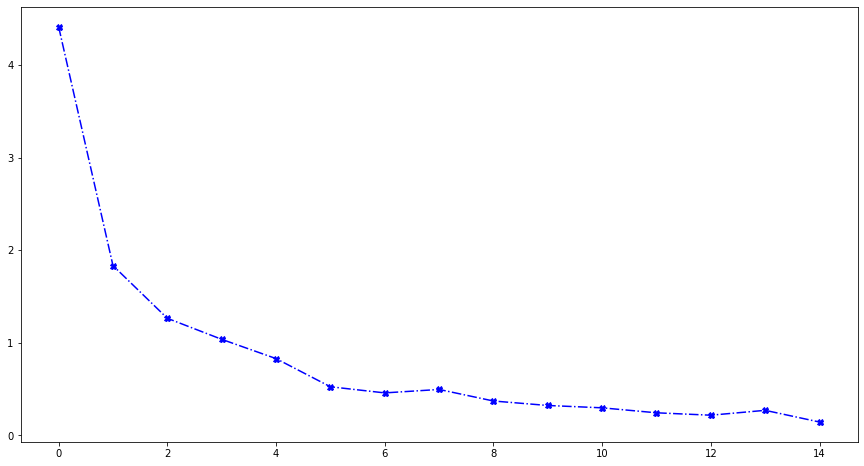

In [22]:
plt.rcParams["figure.figsize"] = (15,8)
plt.plot(all_train_loss, ls='-.', marker = 'X', color='blue')

In [23]:
stop_

NameError: name 'stop_' is not defined

In [ ]:
# chk_1 =tokenizer('MaterialsComp', 
#           padding="max_length", 
#           truncation=True, 
#           max_length=6)

In [ ]:
# tokenizer.batch_decode(chk_1['input_ids'], skip_special_tokens=True, clean_up_tokenization_spaces=False)

In [ ]:
# chk_2 =tokenizer('Ease of use', 
#           padding="max_length", 
#           truncation=True, 
#           max_length=6)

In [ ]:
# tokenizer.batch_decode(chk_2['input_ids'], skip_special_tokens=True, clean_up_tokenization_spaces=False)

In [ ]:
# chk_ = tokenizer('Compartments', 
#           padding="max_length", 
#           truncation=True, 
#           max_length=4)

In [ ]:
# tokenizer.batch_decode(chk_['input_ids'], 
#                        skip_special_tokens=True, 
#                        clean_up_tokenization_spaces=False)

In [ ]:
electronic_topics = open('electronics_40_topics').read()
electronic_topics = electronic_topics.split('\n')

In [ ]:
electronic_topics = [x for ind, x in enumerate(electronic_topics) if ind%2==0]

In [ ]:
electronic_topics = [x.replace("'", "") for x in electronic_topics]
electronic_topics = [x.replace("[", "") for x in electronic_topics]
electronic_topics = [x.replace("]", "") for x in electronic_topics]
electronic_topics = [x.replace(",", "") for x in electronic_topics]
electronic_topics = [x.split(' ')[1:] for x in electronic_topics]

In [ ]:
electronic_topics = [x[:20] for x in electronic_topics]

In [ ]:
test_data = []
for each_e_top in electronic_topics:
    test_data.append({'seeds': each_e_top[:20], 'aspect':'TestSet'})

In [ ]:
test_dataset = aspectDataset(list_data=test_data, 
                              tokenizer=tokenizer)

In [ ]:
test_loader = DataLoader(test_dataset, 
                         batch_size=1, 
                         shuffle=True,
                         num_workers=1)

In [ ]:
model.eval()
for ind, batch in enumerate(test_loader):
    batch = {k: v.to('cuda') for k, v in batch.items()}
    model_op = model(**batch)
    print('---'*20)
    print('ID:', ind)
    print('---'*20)
    print('Seed words:', tokenizer.batch_decode(batch['input_ids'], skip_special_tokens=True, clean_up_tokenization_spaces=False))
    print('Actual aspect:', tokenizer.batch_decode(batch['decoder_input_ids'], skip_special_tokens=True, clean_up_tokenization_spaces=False))
    output_ids = model.generate(batch["input_ids"], num_beams=3, max_length=6)
    print('Predicted aspect:', tokenizer.batch_decode(output_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True))

In [ ]:
model_op['logits'].squeeze(dim=0).shape

In [ ]:
torch.argmax(model_op['logits'].squeeze(dim=0), dim=1)

## Orphan Code
-------------

In [ ]:
print(another_way_to_train)
for epoch in range(num_epochs):
    training_loss = 0.0
    model.train()
    for batch in tqdm(train_loader):
        batch = {k: v.to('cuda') for k, v in batch.items()}
        
        # Get the "input's representation"
        encoder_output = the_encoder(input_ids = batch['input_ids'],
                                   attention_mask = batch['attention_mask'])
      
        # Pass the representation + the target summary to the decoder
        decoder_output = the_decoder(input_ids=batch['decoder_input_ids'],
                                   attention_mask=batch['decoder_attention_mask'],
                                   encoder_hidden_states=encoder_output[0],
                                   encoder_attention_mask=batch['attention_mask'])

        # Use the last linear layer to predict the next token
        decoder_output = decoder_output.last_hidden_state
        lm_head_output = last_linear_layer(decoder_output)
        
        # Compute the loss
        loss = loss_fct(lm_head_output.view(-1, model.config.vocab_size),
                      batch['labels'].view(-1))
        training_loss += loss.item()
        
        loss.backward() # Update the weights
        optimizer.step() # Notify optimizer that a batch is done.
        lr_scheduler.step() # Notify the scheduler that a ...
        optimizer.zero_grad() # Reset the optimer
    training_loss = training_loss / len( train_data )
    print("Epoch {}:\tTraining Loss {:.2f}".format(epoch+1, training_loss))

In [ ]:
lm_head_output.view(-1, model.config.vocab_size)